## Comparison of experimental and theoretical localisation precision


In [22]:
# load modules functions

import os

import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rc('image', cmap='afmhot')
mpl.rc('font', size=14)
mpl.rc('lines', linewidth=1.5)

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['figure.figsize'] = [5, 3.5]

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

%matplotlib notebook
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

from skimage.feature import corner_peaks, peak_local_max
from scipy.ndimage import minimum_filter, gaussian_filter
from scipy.optimize import least_squares, minimize
from scipy.integrate import quad
import scipy as sp

import skimage.io as skio
import ipywidgets as ipw

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [23]:
# Assumes there is only one tif file per folder
folder_name = os.getcwd()
files = os.listdir()
file = [i for i in files if i.endswith(r'tif')]
full_file = os.path.join(folder_name, file[0])


In [24]:

imgs = skio.imread(full_file)
img = imgs[:10].mean(0)
 

In [25]:
# Load rois and fit parameters

file_rois = r"rois.npz"
full_file_rois = os.path.join( folder_name, file_rois )
file_data_arr = np.load( full_file_rois )
data_arr, peaks = file_data_arr['data_arr'], file_data_arr['peaks']

file_ls = r"LS-fit.npz"
full_file_ls = os.path.join( folder_name, file_ls )
file_ls = np.load( full_file_ls )
params_ls, coeff_ls, all_fits_ls, variance_ls = file_ls['params_ls'], file_ls['coeff_ls'], file_ls['all_fits_ls'], file_ls['variance_ls']

file_mle = r"MLE-fit.npz"
full_file_mle = os.path.join( folder_name, file_mle )
file_mle = np.load( full_file_mle )
var_names = list( file_mle.keys() )
params_mle, coeff_mle, all_fits_mle, variance_mle = file_mle['params_mle'], file_mle['coeff_mle'], file_mle['all_fits_mle'], file_mle['variance_mle']




In [26]:
em_gain = 1.99
offset = 2308
sensitivity = 5.35
threshold = 60_000

a = 89
WINDOW = 15
win_2 = WINDOW//2 
n_peaks = peaks.shape[0]
n_frames = data_arr.shape[1]


<IPython.core.display.Javascript object>


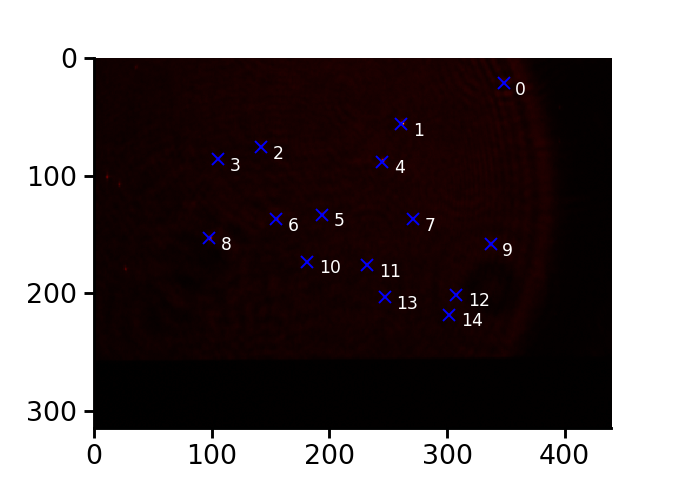

In [27]:
f,ax = plt.subplots()

ax.imshow( img, vmax=img.max() )

for i,peak in enumerate(peaks):
    ax.plot(peak[1], peak[0], 'x', color='b')
    ax.text(peak[1]+10, peak[0]+10, str(i), color='w', fontsize='9')
    

### Select or remove beads manually in this cell if they look too bad


In [28]:
beads_idx = np.arange(n_peaks)

beads_to_keep = beads_idx
beads_to_remove = np.array([], dtype=np.int)
n_beads_to_keep = beads_to_keep.size - beads_to_remove.size


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [29]:
data_arr = np.delete(data_arr, beads_to_remove, axis=0)
peaks = np.delete(peaks, beads_to_remove, axis=0)

params_ls = params_ls.reshape(n_peaks, n_frames, -1)
params_ls = np.delete(params_ls, beads_to_remove, axis=0)

coeff_ls = coeff_ls.reshape(n_peaks, n_frames, -1)
coeff_ls = np.delete(coeff_ls, beads_to_remove, axis=0)

all_fits_ls = all_fits_ls.reshape(n_peaks, n_frames, WINDOW, WINDOW)
all_fits_ls = np.delete(all_fits_ls, beads_to_remove, axis=0)

variance_ls = variance_ls.reshape(-1,n_peaks, n_frames)
variance_ls = np.delete(variance_ls, beads_to_remove, axis=1)

params_mle = params_mle.reshape(n_peaks, n_frames, -1)
params_mle = np.delete(params_mle, beads_to_remove, axis=0)

coeff_mle = coeff_mle.reshape(n_peaks, n_frames, -1)
coeff_mle = np.delete(coeff_mle, beads_to_remove, axis=0)

all_fits_mle = all_fits_mle.reshape(n_peaks, n_frames, WINDOW, WINDOW)
all_fits_mle = np.delete(all_fits_mle, beads_to_remove, axis=0)

variance_mle = variance_mle.reshape(-1,n_peaks, n_frames)
variance_mle = np.delete(variance_mle, beads_to_remove, axis=1)


<IPython.core.display.Javascript object>


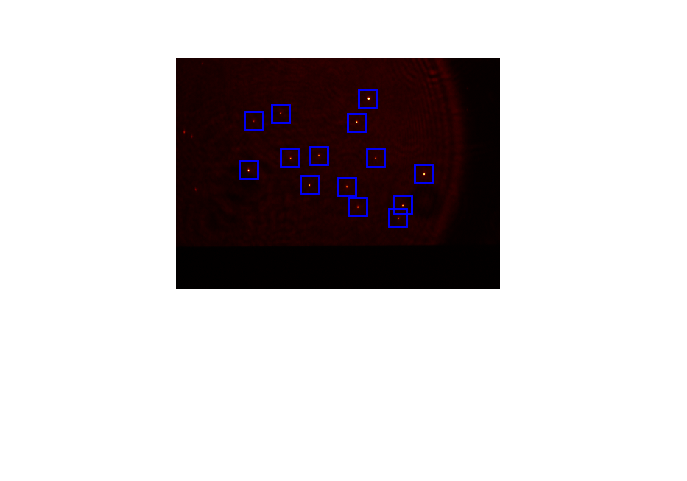

In [30]:
f,ax = plt.subplots()

ax.imshow(img, vmax=img.max()*0.7)
ax.set_xticks([])
ax.set_yticks([])

linelen = 5_000 # nm
ax.plot([400, 400+linelen/a],[480]*2,color='w',linewidth=2)

for i,peak in enumerate(peaks):
    ax.plot(peak[1], peak[0], 's', color='b', markerfacecolor='none', markersize=9)
    
ax.set_frame_on(False)   


#### Remove ROIs with max intensity > 60,000, detector is saturated

In [31]:

counts_arr = data_arr*em_gain/sensitivity + offset
max_values = np.max(counts_arr, axis=(1,2,3) ) # max values shape (n_beads_to_keep,)
idx_saturation = np.where(max_values > threshold)[0]


In [32]:
idx_saturation

array([], dtype=int64)

In [33]:
beads_to_remove = idx_saturation

data_arr = np.delete(data_arr, beads_to_remove, axis=0)
peaks = np.delete(peaks, beads_to_remove, axis=0)

n_peaks = peaks.shape[0]

params_ls = params_ls.reshape(n_peaks, n_frames, -1)
params_ls = np.delete(params_ls, beads_to_remove, axis=0)

coeff_ls = coeff_ls.reshape(n_peaks, n_frames, -1)
coeff_ls = np.delete(coeff_ls, beads_to_remove, axis=0)

all_fits_ls = all_fits_ls.reshape(n_peaks, n_frames, WINDOW, WINDOW)
all_fits_ls = np.delete(all_fits_ls, beads_to_remove, axis=0)

variance_ls = variance_ls.reshape(-1,n_peaks, n_frames)
variance_ls = np.delete(variance_ls, beads_to_remove, axis=1)

params_mle = params_mle.reshape(n_peaks, n_frames, -1)
params_mle = np.delete(params_mle, beads_to_remove, axis=0)

coeff_mle = coeff_mle.reshape(n_peaks, n_frames, -1)
coeff_mle = np.delete(coeff_mle, beads_to_remove, axis=0)

all_fits_mle = all_fits_mle.reshape(n_peaks, n_frames, WINDOW, WINDOW)
all_fits_mle = np.delete(all_fits_mle, beads_to_remove, axis=0)

variance_mle = variance_mle.reshape(-1,n_peaks, n_frames)
variance_mle = np.delete(variance_mle, beads_to_remove, axis=1)

n_beads_to_keep = data_arr.shape[0]


#### Get absolute coordinates from PSF fit

In [34]:
# absolute position from MLE fit
peak_coord_in_nm = peaks*a
xy_shift_mle_in_pix = params_mle[:,:,[0,2]] # shape (n_peaks, n_frames, 2)

# absolute position from LS fit
xy_shift_ls_in_pix = params_ls[:, :, [0, 2]]
abs_position_ls_in_pix = np.fliplr( peaks )[:,None,:] + xy_shift_ls_in_pix
abs_position_ls_in_nm = abs_position_ls_in_pix*a

abs_position_mle_in_pix = np.fliplr( peaks )[:,None,:] + xy_shift_mle_in_pix
abs_position_mle_in_nm = abs_position_mle_in_pix*a


### Get interbead distance localisation precision though error propagation


In [35]:
# error in interbead distance though error propagation

localization_precision_mle = np.sqrt( variance_mle ) 
localization_precision_ls = np.sqrt( variance_ls )
# localization_precision_ls shape (2, n_beads_to_keep, n_frames)

localization_precision_mle_x, localization_precision_mle_y = localization_precision_mle
localization_precision_ls_x, localization_precision_ls_y = localization_precision_ls

# error in interbead distance calculated trough error propagation, includes duplicates
error_mle_x = np.sqrt( localization_precision_mle_x[None,:,:]**2 + localization_precision_mle_x[:,None,:]**2 )
error_ls_x = np.sqrt( localization_precision_ls_x[None,:,:]**2 + localization_precision_ls_x[:,None,:]**2 )

error_mle_y = np.sqrt( localization_precision_mle_y[None,:,:]**2 + localization_precision_mle_y[:,None,:]**2 )
error_ls_y = np.sqrt( localization_precision_ls_y[None,:,:]**2 + localization_precision_ls_y[:,None,:]**2 )

triu_indices = np.triu_indices( n_beads_to_keep, k=1 )
error_interbead_mle_x = error_mle_x[triu_indices] # shape (n_unique_pairs, n_frames)
error_interbead_ls_x = error_ls_x[triu_indices] # shape (n_unique_pairs, n_frames)

error_interbead_mle_y = error_mle_y[triu_indices] # shape (n_unique_pairs, n_frames)
error_interbead_ls_y = error_ls_y[triu_indices] # shape (n_unique_pairs, n_frames)


## Experimental interbead distance in either x or y axis

In [36]:

all_pairs_distances_mle = abs_position_mle_in_nm[None, :, :] - abs_position_ls_in_nm[:, None, :, :] 
distances_no_duplicates_mle_x = all_pairs_distances_mle[triu_indices][...,0]
distances_no_duplicates_mle_y = all_pairs_distances_mle[triu_indices][...,1] # shape (n_unique_pairs, n_frames)

all_pairs_distances_ls = abs_position_ls_in_nm[None, :, :] - abs_position_ls_in_nm[:, None, :, :] 
distances_no_duplicates_ls_x = all_pairs_distances_ls[triu_indices][...,0]
distances_no_duplicates_ls_y = all_pairs_distances_ls[triu_indices][...,1] # shape (n_unique_pairs, n_frames)


### Use parameters from the x axis, for example

In [37]:
distances_no_duplicates = distances_no_duplicates_mle_x
centroid_vals = xy_shift_mle_in_pix.reshape(n_beads_to_keep, n_frames,2) + win_2

mean_distances = distances_no_duplicates.mean( axis=(1) )
distances_zero_centered = distances_no_duplicates-mean_distances[:,None]

hist_data = [np.histogram(i, bins=20) for i in distances_zero_centered]

def center_bins(bins):
    return (bins[:-1] + bins[1:]) / 2 

def get_bin_width(bins, width_factor=1):
    return width_factor * (bins[1] - bins[0])

bins = [center_bins(i[1]) for i in hist_data]
widths = [get_bin_width(i[1]) for i in hist_data]
counts = [ i[0]/(i[0].sum()*j) for i,j in zip(hist_data, widths) ] # integral normalized to 1
std_experimental_from_ls_fit_x = np.std( distances_zero_centered, axis=1)

def compute_gaussian(sigma):
    # mean is centered around 0
    x = np.linspace(-4*sigma, 4*sigma, num=100).T
    gaussian =  1/( sigma * np.sqrt(2 * np.pi) ) * np.exp(-x**2 / (2 * sigma**2) )
    return x, gaussian

n_x = [compute_gaussian(i)[0] for i in std_experimental_from_ls_fit_x]
gauss = [compute_gaussian(i)[1] for i in std_experimental_from_ls_fit_x]

mean_error = np.std(distances_no_duplicates, axis=1)


### Function to plot interbead distance

In [38]:
n_rois = n_beads_to_keep*n_frames
data_arr_for_fit = data_arr.reshape(-1, WINDOW, WINDOW)

def plot_distance(n, distances_no_duplicates, axis='x'):
   
    ax_hist.cla()
    ax_hist.bar(bins[n], counts[n], width=widths[n], color='skyblue', edgecolor='k')
    ax_hist.plot(n_x[n], gauss[n], linewidth=2, color='r')

    ax_trace.cla()
    # Plot the raw data
    ax_trace.plot(distances_no_duplicates[n], 'k')
    ax_trace.axhline(y=mean_distances[n], color='red', linestyle='--', label='Center Line')
    
    # Set titles and labels
    #ax_hist.set_title(f'Histogram of Distances for Bead Pair {n}')
    ax_hist.set_title( f'Error {mean_error[n]:.3f}')
    ax_hist.set_xlabel('Distance (nm)')
    ax_hist.set_ylabel('Frequency')
    #ax1.legend(['Gaussian', 'Histogram'], loc='upper right')
    
    ax_trace.set_title(f'Distances for Bead Pair {n}')
    ax_trace.set_xlabel('Frames')
    ax_trace.set_ylabel('Distance / nm')
    
    plt.show()


### Add subplots with beads fit, see why some bead pairs drift so much  

<IPython.core.display.Javascript object>


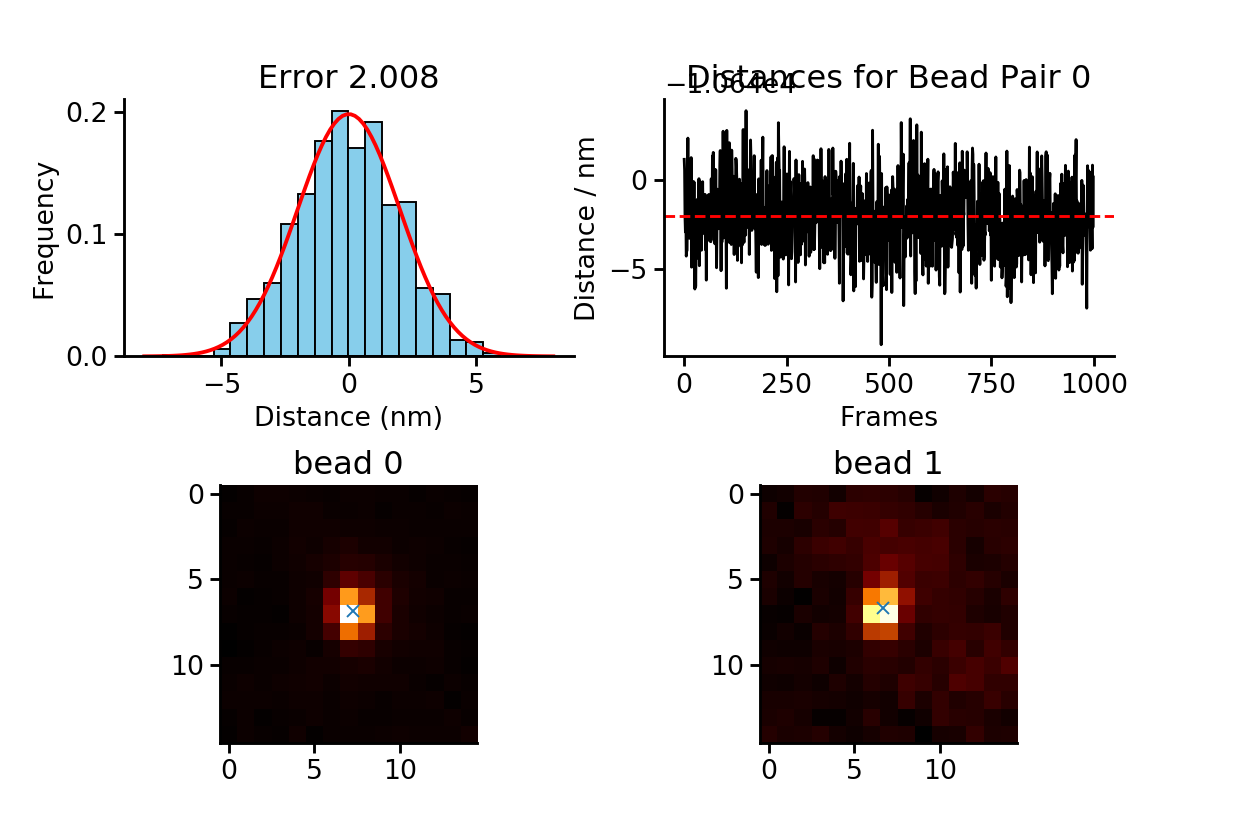

interactive(children=(IntSlider(value=0, description='frame_num', max=999), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=0, description='bead_idx', max=90), Output()), _dom_classes=('widget-int…

In [39]:
fig, ((ax_hist, ax_trace), (ax_left, ax_right)) = plt.subplots(2, 2, figsize=(9, 6),
                                                           gridspec_kw={'left':0.1, 'bottom':0.1,'hspace':0.5})

frame_widget = ipw.IntSlider(min=0, max=n_frames-1, step=1)  
bead_idx_widget = ipw.IntSlider(min=0, max=distances_no_duplicates.shape[0]-1, step=1) 
max_vals = data_arr.max( axis=(1,2,3) )

n = 0
idx_left = triu_indices[0][n]
idx_right = triu_indices[1][n]

im_left = ax_left.imshow(data_arr[idx_left, 0], vmax=max_vals[0])
im_right = ax_right.imshow(data_arr[idx_right, 0], vmax=max_vals[0])
line_fit_left, = ax_left.plot(*centroid_vals[idx_left, 0], 'x')
line_fit_right, = ax_right.plot(*centroid_vals[idx_right, 0], 'x')

      
def update_bead_idx(bead_idx, distances_no_duplicates):
    
    plot_distance(bead_idx, distances_no_duplicates)
    idx_left = triu_indices[0][bead_idx]
    idx_right = triu_indices[1][bead_idx]
    
    im_left.set_data( data_arr[idx_left, 0] )
    im_left.set_clim(vmax=max_vals[idx_left])   
    im_right.set_data( data_arr[idx_right, 0] )
    im_right.set_clim(vmax=max_vals[idx_right])
    
    line_fit_left.set_data(*centroid_vals[idx_left, 0])
    line_fit_right.set_data(*centroid_vals[idx_right, 0])
    
    fig.canvas.draw_idle()
    ax_left.set_title(f'bead {idx_left}')
    ax_right.set_title(f'bead {idx_right}')    
    
    frame_widget.value = 0
    
        
def update_frame(frame_num):
    
    bead_idx = bead_idx_widget.value
    idx_left = triu_indices[0][bead_idx]
    idx_right = triu_indices[1][bead_idx]
    
    im_left.set_data( data_arr[idx_left, frame_num] )
    im_left.set_clim(vmax=max_vals[idx_left])   
    im_right.set_data( data_arr[idx_right, frame_num] )
    im_right.set_clim(vmax=max_vals[idx_right])
    
    line_fit_left.set_data(*centroid_vals[idx_left, frame_num])
    line_fit_right.set_data(*centroid_vals[idx_right, frame_num])
    
    fig.canvas.draw_idle()
    ax_left.set_title(f'bead {idx_left}')
    ax_right.set_title(f'bead {idx_right}')
    
ipw.interact( update_frame, frame_num=frame_widget );
ipw.interact( update_bead_idx, bead_idx=bead_idx_widget, 
              distances_no_duplicates=ipw.fixed(distances_no_duplicates) );



In [40]:
# use x axis for example
mean_distances_ls = distances_no_duplicates_ls_x.mean( axis=(1) )
distances_zero_centered_ls = distances_no_duplicates_ls_x - mean_distances_ls[:,None]
std_experimental_from_ls_fit_x = np.std( distances_zero_centered_ls, axis=1)
mean_error_ls = error_interbead_ls_x.mean(1) # do the average over all frames

mean_distances_mle = distances_no_duplicates_mle_x.mean( axis=(1) )
distances_zero_centered_mle = distances_no_duplicates_mle_x - mean_distances_mle[:,None]
std_experimental_from_mle_fit_x = np.std( distances_zero_centered_mle, axis=1)
mean_error_mle = error_interbead_mle_x.mean(1) # do the average over all frames


<IPython.core.display.Javascript object>


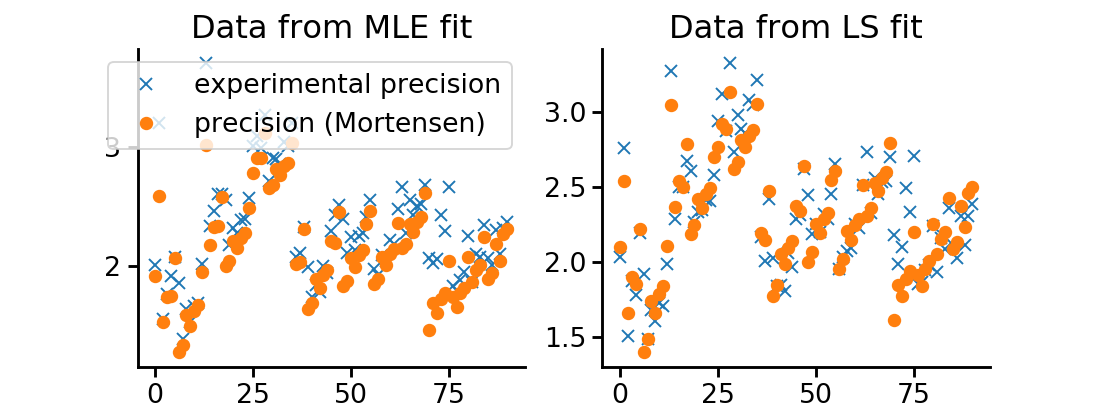

Text(0.5, 1.0, 'Data from LS fit')

In [41]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3) )

ax1.plot(std_experimental_from_mle_fit_x, 'x')
ax1.plot(mean_error_mle, 'o')
ax1.legend(['experimental precision', 'precision (Mortensen)'])
ax1.set_title('Data from MLE fit')

ax2.plot(std_experimental_from_ls_fit_x, 'x')
ax2.plot(mean_error_ls, 'o')
#ax2.legend(['experimental precision', 'precision (Mortensen)'])
ax2.set_title('Data from LS fit')


<IPython.core.display.Javascript object>


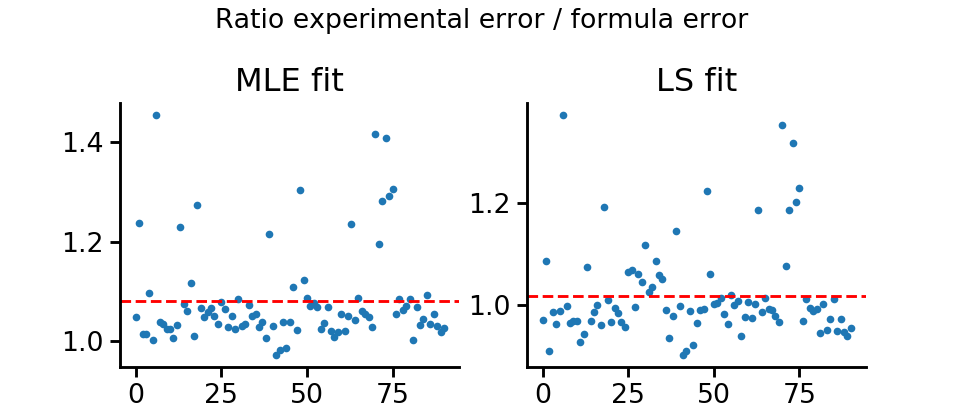

Text(0.5, 0.98, 'Ratio experimental error / formula error')

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), gridspec_kw={'top':0.75} )

ratio_mle = std_experimental_from_mle_fit_x/mean_error_mle
ratio_ls = std_experimental_from_ls_fit_x/mean_error_ls

ax1.plot( ratio_mle, '.')
ax1.axhline(ratio_mle.mean(), color='r', linestyle='--')
ax1.set_title('MLE fit')

ax2.plot( ratio_ls , '.')
ax2.axhline(ratio_ls.mean(), color='r', linestyle='--')
ax2.set_title('LS fit')

f.suptitle('Ratio experimental error / formula error', fontsize=14)


### Error propagation Euclidean distance

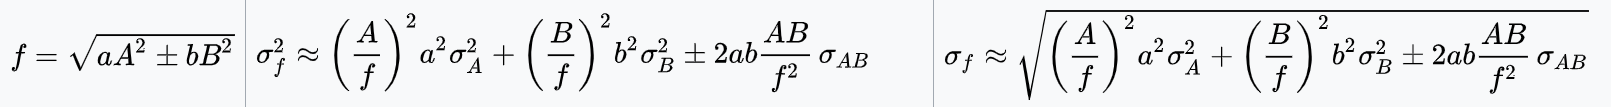


We assume $\sigma_{AB}=0$, so we neclect the last term



if  $f$  is the euclidean distance:

$$f = \sqrt{x^2+y^2}$$

then the error:

$$\sigma_{xy}=\sqrt{ \left(\frac{x}{f}\right)^2\sigma_x^2 + \left(\frac{y}{f}\right)^2\sigma_y^2}$$


In [43]:

interbead_euclidean_distance_ls = np.sqrt( distances_no_duplicates_ls_x**2 + distances_no_duplicates_ls_y**2 )
interbead_euclidean_distance_mle = np.sqrt( distances_no_duplicates_mle_x**2 + distances_no_duplicates_mle_y**2 )

# calculated from formula
error_interbead_ls_euclidean = np.sqrt( (distances_no_duplicates_ls_x/interbead_euclidean_distance_ls)**2*error_interbead_ls_x**2+
                                    (distances_no_duplicates_ls_y/interbead_euclidean_distance_ls)**2*error_interbead_ls_y**2 )

error_interbead_mle_euclidean = np.sqrt( (distances_no_duplicates_mle_x/interbead_euclidean_distance_mle)**2*error_interbead_mle_x**2+
                                    (distances_no_duplicates_mle_y/interbead_euclidean_distance_mle)**2*error_interbead_mle_y**2 )

std_experimental_from_ls_fit_euclidean = np.std(interbead_euclidean_distance_ls, axis=1)
std_experimental_from_mle_fit_euclidean = np.std(interbead_euclidean_distance_mle, axis=1)

mean_error_ls_euclidean = error_interbead_ls_euclidean.mean(1)
mean_error_mle_euclidean = error_interbead_mle_euclidean.mean(1)


<IPython.core.display.Javascript object>


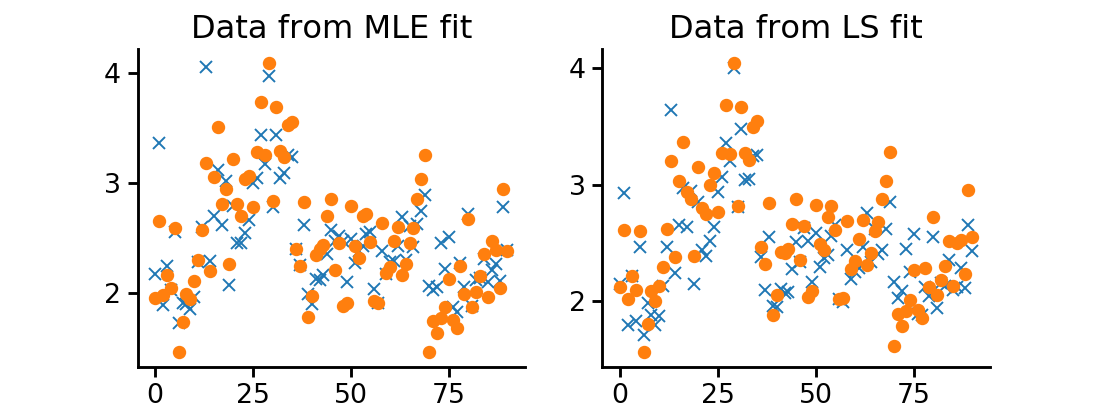

Text(0.5, 1.0, 'Data from LS fit')

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3) )

ax1.plot(std_experimental_from_mle_fit_euclidean, 'x')
ax1.plot(mean_error_mle_euclidean, 'o')
#ax1.legend(['experimental precision', 'precision (Mortensen)'])
ax1.set_title('Data from MLE fit')

ax2.plot(std_experimental_from_ls_fit_euclidean, 'x')
ax2.plot(mean_error_ls_euclidean, 'o')
#ax2.legend(['experimental precision', 'precision (Mortensen)'])
ax2.set_title('Data from LS fit')


<IPython.core.display.Javascript object>


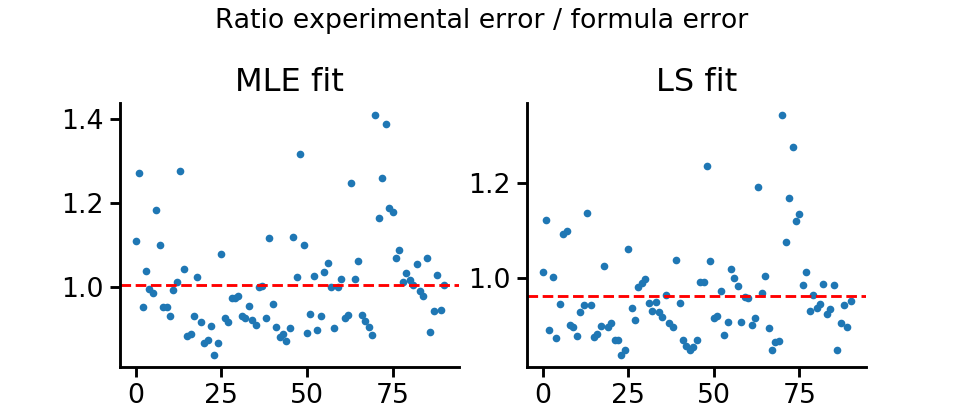

Text(0.5, 0.98, 'Ratio experimental error / formula error')

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), gridspec_kw={'top':0.75} )

ratio_ls = std_experimental_from_ls_fit_euclidean/mean_error_ls_euclidean
ratio_mle = std_experimental_from_mle_fit_euclidean/mean_error_mle_euclidean

ax1.plot( ratio_mle, '.')
ax1.axhline(ratio_mle.mean(), color='r', linestyle='--')
ax1.set_title('MLE fit')

ax2.plot( ratio_ls , '.')
ax2.axhline(ratio_ls.mean(), color='r', linestyle='--')
ax2.set_title('LS fit')

f.suptitle('Ratio experimental error / formula error', fontsize=14)


### Remove 20% worst ones

In [46]:
n_bead_pairs = distances_no_duplicates.shape[0]
partition_point = n_bead_pairs*8//10

idx_to_keep = np.argpartition(std_experimental_from_ls_fit_euclidean, partition_point)[:partition_point]

std_experimental_from_ls_fit_euclidean_best = std_experimental_from_ls_fit_euclidean[idx_to_keep]
mean_error_ls_euclidean_best = mean_error_ls_euclidean[idx_to_keep]

std_experimental_from_mle_fit_euclidean_best = std_experimental_from_mle_fit_euclidean[idx_to_keep]
mean_error_mle_euclidean_best = mean_error_mle_euclidean[idx_to_keep]


<IPython.core.display.Javascript object>


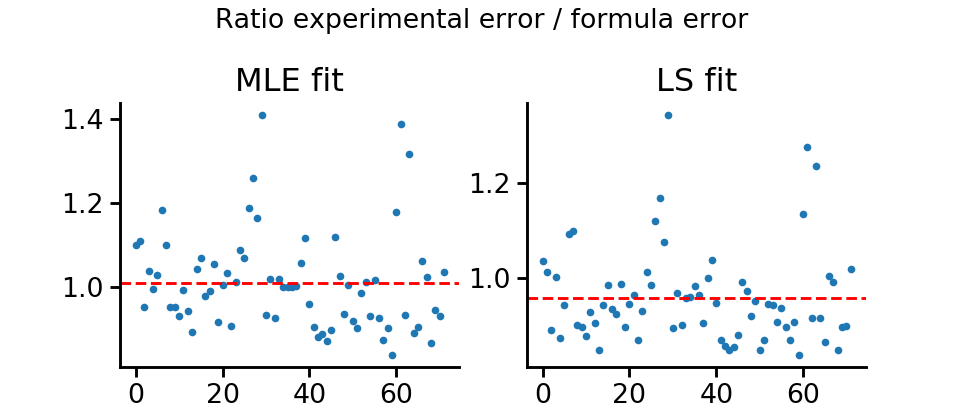

Text(0.5, 0.98, 'Ratio experimental error / formula error')

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), gridspec_kw={'top':0.75} )

ratio_ls = std_experimental_from_ls_fit_euclidean_best/mean_error_ls_euclidean_best
ratio_mle = std_experimental_from_mle_fit_euclidean_best/mean_error_mle_euclidean_best

ax1.plot( ratio_mle, '.')
ax1.axhline(ratio_mle.mean(), color='r', linestyle='--')
ax1.set_title('MLE fit')

ax2.plot( ratio_ls , '.')
ax2.axhline(ratio_ls.mean(), color='r', linestyle='--')
ax2.set_title('LS fit')

f.suptitle('Ratio experimental error / formula error', fontsize=14)


In [32]:
print( np.median(ratio_ls) )
print( np.median(ratio_mle) )


0.9401897312724279
0.9933114816065212


<IPython.core.display.Javascript object>


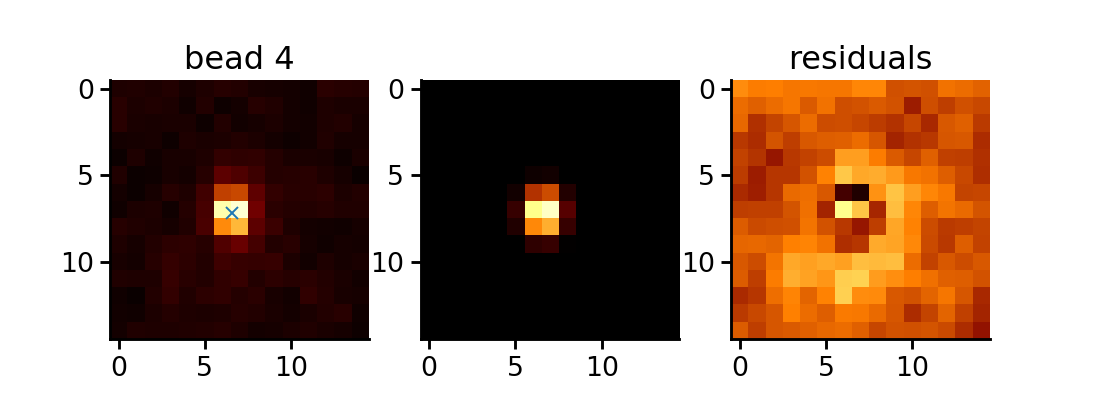

interactive(children=(IntSlider(value=0, description='frame_num', max=999), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=0, description='bead_idx', max=13), Output()), _dom_classes=('widget-int…

In [49]:
fig, (ax_data, ax_fit, ax_res) = plt.subplots(1, 3, figsize=(8, 3),gridspec_kw={'left':0.1, 'bottom':0.1,'hspace':0.5})

frame_widget = ipw.IntSlider(min=0, max=n_frames-1, step=1)  
bead_idx_widget = ipw.IntSlider(min=0, max=n_beads_to_keep-1, step=1) 

max_vals = data_arr.max( axis=(1,2,3) )
centroid_vals = xy_shift_mle_in_pix.reshape(n_beads_to_keep, n_frames,2) + win_2

bead_idx = 0
residuals_ls = data_arr - all_fits_ls
residuals_mle  = data_arr - all_fits_mle

n_ = 10
tt = sp.ndimage.convolve1d(residuals_mle, np.ones(n_), axis=1)/n_

avg_res = residuals_mle.mean(1)

im_data = ax_data.imshow(data_arr[n, 0], vmax=max_vals[0])
im_fit = ax_fit.imshow(all_fits_ls[n,0], vmax=max_vals[0])
im_res = ax_res.imshow( residuals_ls[n, 0] )
line_fit, = ax_data.plot(*centroid_vals[n, 0], 'x')
ax_res.set_title(f'residuals')  


def update_bead_idx(bead_idx):
    
    im_data.set_data( data_arr[bead_idx, 0] )
    im_data.set_clim(vmax=max_vals[bead_idx])  
    
    im_fit.set_data( all_fits_ls[bead_idx, 0] )
    im_fit.set_clim(vmax=max_vals[bead_idx]) 
    
    im_res.set_data( tt[bead_idx, 0] )
    #im_res.set_data( avg_res[bead_idx] )
    im_res.set_clim(vmax=tt[bead_idx].max(), vmin=tt[bead_idx].min()) 
    
    line_fit.set_data(*centroid_vals[bead_idx, 0])
    
    fig.canvas.draw_idle()
    ax_data.set_title(f'bead {bead_idx}')
         
    frame_widget.value = 0
    
def update_frame(frame_num):
    
    bead_idx = bead_idx_widget.value
    
    im_data.set_data( data_arr[bead_idx, frame_num] )
    im_data.set_clim(vmax=max_vals[bead_idx])
    
    im_fit.set_data( all_fits_ls[bead_idx, frame_num] )
    im_fit.set_clim(vmax=max_vals[bead_idx])
    
    im_res.set_data( tt[bead_idx, frame_num] )
    #im_res.set_data( avg_res[bead_idx] )

    line_fit.set_data(*centroid_vals[bead_idx, frame_num])
    
    fig.canvas.draw_idle()
    
    #ax_left.set_title(f'bead {idx_left}')
    #ax_right.set_title(f'bead {idx_right}')
    
ipw.interact( update_frame, frame_num=frame_widget );
ipw.interact( update_bead_idx, bead_idx=bead_idx_widget, 
              distances_no_duplicates=ipw.fixed(distances_no_duplicates) );

